# Train a Vision Transformer on small datasets

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498)<br>
**Date created:** 2022/01/07<br>
**Last modified:** 2022/01/10<br>
**Description:** Training a ViT from scratch on smaller datasets with shifted patch tokenization and locality self-attention.

## Introduction

In the academic paper
[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929),
the authors mention that Vision Transformers (ViT) are data-hungry. Therefore,
pretraining a ViT on a large-sized dataset like JFT300M and fine-tuning
it on medium-sized datasets (like ImageNet) is the only way to beat
state-of-the-art Convolutional Neural Network models.

The self-attention layer of ViT lacks **locality inductive bias** (the notion that
image pixels are locally correlated and that their correlation maps are translation-invariant).
This is the reason why ViTs need more data. On the other hand, CNNs look at images through
spatial sliding windows, which helps them get better results with smaller datasets.

In the academic paper
[Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1),
the authors set out to tackle the problem of locality inductive bias in ViTs.

The main ideas are:

- **Shifted Patch Tokenization**
- **Locality Self Attention**

This example implements the ideas of the paper. A large part of this
example is inspired from
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

_Note_: This example requires TensorFlow 2.6 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons), which can be
installed using the following command:

```python
pip install -qq -U tensorflow-addons
```

In [1]:
!pip install -qq -U tensorflow-addons

## Setup

In [6]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

/Users/marcosplazagonzalez/miniforge3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Prepare the data

In [13]:
NUM_CLASSES=5
IMAGE_SIZE=128
N_CHANNELS=3
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS)

In [14]:
from DataLoader import DataLoader
data = DataLoader("ViT")
data.load_data("/Users/marcosplazagonzalez/Desktop/Ground-based_CloudClassification/Datasets/FabraClouds256_TrainTest/train", IMAGE_SIZE, N_CHANNELS)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:18<00:00,  1.67s/it]


In [15]:
from sklearn.model_selection import train_test_split

# split into train and validation
X_train, X_val, y_train, y_val = train_test_split(data.X, data.y, test_size=0.3, random_state=42)

In [16]:
print("X_train shape {}".format(X_train.shape))
print("X_val shape {}".format(X_val.shape))
print("y_train shape {}".format(y_train.shape))
print("y_val shape {}".format(y_val.shape))

X_train shape (1089, 128, 128, 3)
X_val shape (468, 128, 128, 3)
y_train shape (1089, 1)
y_val shape (468, 1)


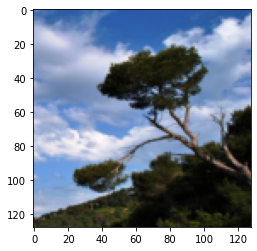

In [17]:
plt.imshow(X_train[502])

In [18]:
y_train

array([[4],
       [0],
       [6],
       ...,
       [6],
       [2],
       [9]], dtype=int32)

## Configure the hyperparameters

The hyperparameters are different from the paper. Feel free to tune
the hyperparameters yourself.

In [19]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 200

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

## Use data augmentation

A snippet from the paper:

*"According to DeiT, various techniques are required to effectively
train ViTs. Thus, we applied data augmentations such as CutMix, Mixup,
Auto Augment, Repeated Augment to all models."*

In this example, we will focus solely on the novelty of the approach
and not on reproducing the paper results. For this reason, we
don't use the mentioned data augmentation schemes. Please feel
free to add to or remove from the augmentation pipeline.

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        #layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

2022-06-28 23:11:12.699067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-28 23:11:12.708663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## Implement Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are
then linearly projected into tokens. Shifted patch tokenization (STP)
is introduced to combat the low receptive field of ViTs. The steps
for Shifted Patch Tokenization are as follows:

- Start with an image.
- Shift the image in diagonal directions.
- Concat the diagonally shifted images with the original image.
- Extract patches of the concatenated images.
- Flatten the spatial dimension of all patches.
- Layer normalize the flattened patches and then project it.

| ![Shifted Patch Toekenization](https://i.imgur.com/bUnHxd0.png) |
| :--: |
| Shifted Patch Tokenization [Source](https://arxiv.org/abs/2112.13492v1) |

In [21]:

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vanilla': self.vanilla,
            'image_size': self.image_size,
            'patch_size': self.patch_size,
            'half_patch': self.half_patch,
            'flatten_patches': self.flatten_patches,
            'projection': self.projection,
            'layer_norm': self.layer_norm
        })
        return config
    
    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


### Visualize the patches

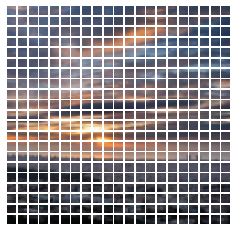

ORIGINAL


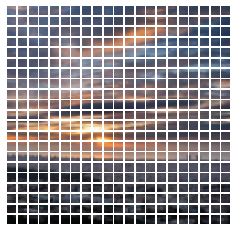

LEFT-UP


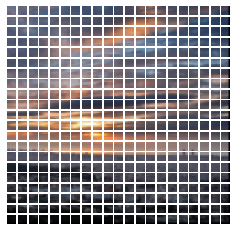

LEFT-DOWN


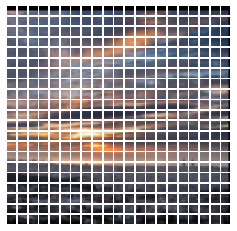

RIGHT-UP


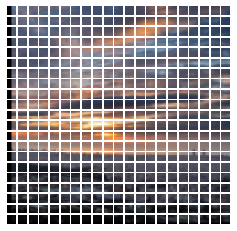

RIGHT-DOWN


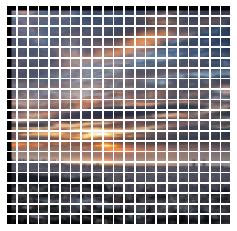

In [22]:
# Get a random image from the training dataset
# and resize the image
image = X_train[np.random.choice(range(X_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

## Implement the patch encoding layer

This layer accepts projected patches and then adds positional
information to them.

In [24]:

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'position_embedding': self.position_embedding,
            'positions': self.positions
        })
        return config
    
    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


## Implement Locality Self Attention

The regular attention equation is stated below.

| ![Equation of attention](https://miro.medium.com/max/396/1*P9sV1xXM10t943bXy_G9yg.png) |
| :--: |
| [Source](https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634) |

The attention module takes a query, key, and value. First, we compute the
similarity between the query and key via a dot product. Then, the result
is scaled by the square root of the key dimension. The scaling prevents
the softmax function from having an overly small gradient. Softmax is then
applied to the scaled dot product to produce the attention weights.
The value is then modulated via the attention weights.

In self-attention, query, key and value come from the same input.
The dot product would result in large self-token relations rather than
inter-token relations. This also means that the softmax gives higher
probabilities to self-token relations than the inter-token relations.
To combat this, the authors propose masking the diagonal of the dot product.
This way, we force the attention module to pay more attention to the
inter-token relations.

The scaling factor is a constant in the regular attention module.
This acts like a temperature term that can modulate the softmax function.
The authors suggest a learnable temperature term instead of a constant.

| ![Implementation of LSA](https://i.imgur.com/GTV99pk.png) |
| :--: |
| Locality Self Attention [Source](https://arxiv.org/abs/2112.13492v1) |

The above two pointers make the Locality Self Attention. We have subclassed the
[`layers.MultiHeadAttention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
and implemented the trainable temperature. The attention mask is built
at a later stage.

In [25]:

class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'tau': self.tau,
        })
        return config
    
    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


## Implement the MLP

In [26]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

## Build the ViT

In [27]:

def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [28]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(X_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    
    callbacks=[]
    checkpoint = ModelCheckpoint("./transformerModels/Test1.h5", monitor="val_accuracy", verbose=1,  save_best_only=True,
                                save_weights_only=False, mode='auto', period=1)
    
    earlystopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=20, verbose=1, mode='auto')
    
    callbacks.append(checkpoint)
    callbacks.append(earlystopping)

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1)
    
    _, accuracy, top_5_accuracy = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

with tf.device("cpu:0"):
    # Run experiments with the vanilla ViT
    vit = create_vit_classifier(vanilla=True)
    history = run_experiment(vit)
    
    with open("./transformerHistorics/Test1_Vanilla_History.pkl", "wb") as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/200


InvalidArgumentError: Cannot assign a device for operation model/data_augmentation/random_flip/stateful_uniform_full_int/RngReadAndSkip: Could not satisfy explicit device specification '' because the node {{colocation_node model/data_augmentation/random_flip/stateful_uniform_full_int/RngReadAndSkip}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
RngReadAndSkip: CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  model_data_augmentation_random_flip_stateful_uniform_full_int_rngreadandskip_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  model/data_augmentation/random_flip/stateful_uniform_full_int/RngReadAndSkip (RngReadAndSkip) 

	 [[{{node model/data_augmentation/random_flip/stateful_uniform_full_int/RngReadAndSkip}}]] [Op:__inference_train_function_23685]

### Results for ViT

In [ ]:
vit.summary()

In [ ]:
data2 = DataLoader()
data2.load_data("./FabraSwimcat_Re_TrainTest_Legal/test", IMAGE_SIZE, N_CHANNELS)

In [86]:
y_pred = vit.predict(data2.X)

In [87]:
def show_result(X_test, y_pred, idx, show_image=False):
    labels = ['Clear Sky', 'Patterned Clouds', 'Thick Dark Clouds',
       'Thick White Clouds', 'Veil Clouds']

    if show_image:
        plt.imshow(X_test[idx])
        plt.show()
    
    print("The classifier says that the image shown is from class -> {}".format(labels[np.argmax(y_pred[idx])]))
    
    return labels[np.argmax(y_pred[idx])]

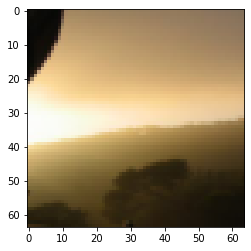

The classifier says that the image shown is from class -> Veil Clouds


'Veil Clouds'

In [88]:
show_result(data2.X, y_pred, 200, show_image=True)

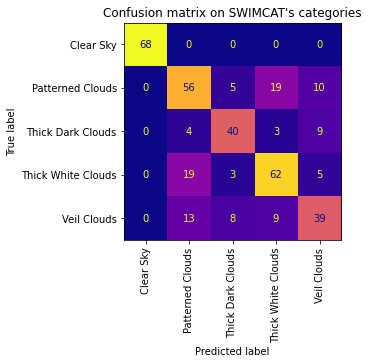

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from IPython.display import display, HTML

matrix = confusion_matrix(data2.y.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data2.class_names)
disp.plot(colorbar=False, cmap='plasma', xticks_rotation='vertical')
plt.title("Confusion matrix on SWIMCAT's categories")
plt.show()

In [90]:
report = classification_report(data2.y.argmax(axis=1), y_pred.argmax(axis=1), target_names=data2.class_names)
print(report) 

                    precision    recall  f1-score   support

         Clear Sky       1.00      1.00      1.00        68
  Patterned Clouds       0.61      0.62      0.62        90
 Thick Dark Clouds       0.71      0.71      0.71        56
Thick White Clouds       0.67      0.70      0.68        89
       Veil Clouds       0.62      0.57      0.59        69

          accuracy                           0.71       372
         macro avg       0.72      0.72      0.72       372
      weighted avg       0.71      0.71      0.71       372



### Results for ViT (No Vanilla)

In [91]:
with tf.device("cpu:0"):
    # Run experiments with the Shifted Patch Tokenization and
    # Locality Self Attention modified ViT
    vit_sl = create_vit_classifier(vanilla=False)
    history = run_experiment(vit_sl)

Epoch 1/200
3/3 [==============================] - 11s 2s/step - loss: 6.6278 - accuracy: 0.3046 - top-5-accuracy: 1.0000 - val_loss: 7.8307 - val_accuracy: 0.2373 - val_top-5-accuracy: 1.0000
Epoch 2/200
3/3 [==============================] - 5s 1s/step - loss: 8.0731 - accuracy: 0.3295 - top-5-accuracy: 1.0000 - val_loss: 2.0842 - val_accuracy: 0.5763 - val_top-5-accuracy: 1.0000
Epoch 3/200
3/3 [==============================] - 5s 1s/step - loss: 3.2347 - accuracy: 0.4004 - top-5-accuracy: 1.0000 - val_loss: 1.3815 - val_accuracy: 0.5085 - val_top-5-accuracy: 1.0000
Epoch 4/200
3/3 [==============================] - 5s 1s/step - loss: 1.8339 - accuracy: 0.4866 - top-5-accuracy: 1.0000 - val_loss: 1.0214 - val_accuracy: 0.5085 - val_top-5-accuracy: 1.0000
Epoch 5/200
3/3 [==============================] - 5s 1s/step - loss: 1.4047 - accuracy: 0.5364 - top-5-accuracy: 1.0000 - val_loss: 0.9729 - val_accuracy: 0.6610 - val_top-5-accuracy: 1.0000
Epoch 6/200
3/3 [======================

Epoch 43/200
3/3 [==============================] - 5s 1s/step - loss: 0.6472 - accuracy: 0.7510 - top-5-accuracy: 1.0000 - val_loss: 1.0336 - val_accuracy: 0.5932 - val_top-5-accuracy: 1.0000
Epoch 44/200
3/3 [==============================] - 5s 1s/step - loss: 0.6598 - accuracy: 0.7682 - top-5-accuracy: 1.0000 - val_loss: 0.8938 - val_accuracy: 0.6780 - val_top-5-accuracy: 1.0000
Epoch 45/200
3/3 [==============================] - 5s 1s/step - loss: 0.5379 - accuracy: 0.7989 - top-5-accuracy: 1.0000 - val_loss: 0.9284 - val_accuracy: 0.7119 - val_top-5-accuracy: 1.0000
Epoch 46/200
3/3 [==============================] - 5s 1s/step - loss: 0.5655 - accuracy: 0.8199 - top-5-accuracy: 1.0000 - val_loss: 0.9655 - val_accuracy: 0.6780 - val_top-5-accuracy: 1.0000
Epoch 47/200
3/3 [==============================] - 5s 1s/step - loss: 0.5245 - accuracy: 0.8199 - top-5-accuracy: 1.0000 - val_loss: 1.2159 - val_accuracy: 0.6102 - val_top-5-accuracy: 1.0000
Epoch 48/200
3/3 [=================

3/3 [==============================] - 5s 1s/step - loss: 0.1626 - accuracy: 0.9444 - top-5-accuracy: 1.0000 - val_loss: 1.1731 - val_accuracy: 0.7627 - val_top-5-accuracy: 1.0000
Epoch 128/200
3/3 [==============================] - 5s 1s/step - loss: 0.1278 - accuracy: 0.9521 - top-5-accuracy: 1.0000 - val_loss: 1.2132 - val_accuracy: 0.7288 - val_top-5-accuracy: 1.0000
Epoch 129/200
3/3 [==============================] - 5s 1s/step - loss: 0.1721 - accuracy: 0.9387 - top-5-accuracy: 1.0000 - val_loss: 1.4231 - val_accuracy: 0.7458 - val_top-5-accuracy: 1.0000
Epoch 130/200
3/3 [==============================] - 5s 1s/step - loss: 0.0711 - accuracy: 0.9713 - top-5-accuracy: 1.0000 - val_loss: 1.6189 - val_accuracy: 0.7458 - val_top-5-accuracy: 1.0000
Epoch 131/200
3/3 [==============================] - 5s 1s/step - loss: 0.1515 - accuracy: 0.9540 - top-5-accuracy: 1.0000 - val_loss: 1.5857 - val_accuracy: 0.7458 - val_top-5-accuracy: 1.0000
Epoch 132/200
3/3 [=========================

In [92]:
vit_sl.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 64, 64, 3)   7           ['input_11[0][0]']               
                                                                                                  
 shifted_patch_tokenization_14   ((None, 100, 64),   35704       ['data_augmentation[10][0]']     
 (ShiftedPatchTokenization)      (None, 10, 10, 540                                               
                                ))                                                                
                                                                                           

 add_165 (Add)                  (None, 100, 64)      0           ['dropout_195[0][0]',            
                                                                  'add_164[0][0]']                
                                                                                                  
 layer_normalization_191 (Layer  (None, 100, 64)     128         ['add_165[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_lsa_19 (M  (None, 100, 64)     66369       ['layer_normalization_191[0][0]',
 ultiHeadAttentionLSA)                                            'layer_normalization_191[0][0]']
                                                                                                  
 add_166 (Add)                  (None, 100, 64)      0           ['multi_head_attention_lsa_19[0][
          

                                                                  'add_171[0][0]']                
                                                                                                  
 layer_normalization_198 (Layer  (None, 100, 64)     128         ['add_172[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 dense_217 (Dense)              (None, 100, 128)     8320        ['layer_normalization_198[0][0]']
                                                                                                  
 dropout_202 (Dropout)          (None, 100, 128)     0           ['dense_217[0][0]']              
                                                                                                  
 dense_218 (Dense)              (None, 100, 64)      8256        ['dropout_202[0][0]']            
          

In [93]:
y_pred = vit_sl.predict(data2.X)

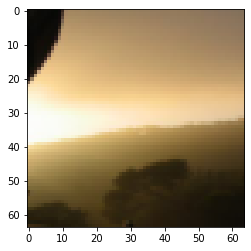

The classifier says that the image shown is from class -> Veil Clouds


'Veil Clouds'

In [94]:
show_result(data2.X, y_pred, 200, show_image=True)

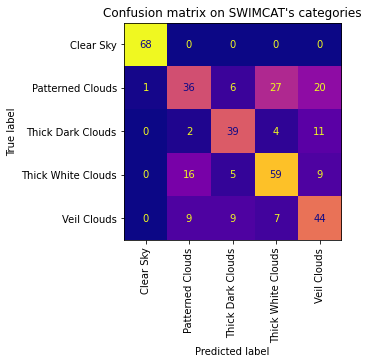

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from IPython.display import display, HTML

matrix = confusion_matrix(data2.y.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data2.class_names)
disp.plot(colorbar=False, cmap='plasma', xticks_rotation='vertical')
plt.title("Confusion matrix on SWIMCAT's categories")
plt.show()

In [96]:
report = classification_report(data2.y.argmax(axis=1), y_pred.argmax(axis=1), target_names=data2.class_names)
print(report) 

                    precision    recall  f1-score   support

         Clear Sky       0.99      1.00      0.99        68
  Patterned Clouds       0.57      0.40      0.47        90
 Thick Dark Clouds       0.66      0.70      0.68        56
Thick White Clouds       0.61      0.66      0.63        89
       Veil Clouds       0.52      0.64      0.58        69

          accuracy                           0.66       372
         macro avg       0.67      0.68      0.67       372
      weighted avg       0.66      0.66      0.66       372



# Final Notes

With the help of Shifted Patch Tokenization and Locality Self Attention,
we were able to get ~**3-4%** top-1 accuracy gains on CIFAR100.

The ideas on Shifted Patch Tokenization and Locality Self Attention
are very intuitive and easy to implement. The authors also ablates of
different shifting strategies for Shifted Patch Tokenization in the
supplementary of the paper.

I would like to thank [Jarvislabs.ai](https://jarvislabs.ai/) for
generously helping with GPU credits.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/vit_small_ds_v2) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/vit-small-ds).